# Proyecto 3 - G3 - ML

## 0. Libraries

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import rcParams
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn import preprocessing

#temp
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import umap
import trimap
import pacmap

from agglomerative_own import AgglomerativeHierarchicalClustering
from kmeans_own import MyKMeans

np.random.seed(2024)

## 1. Video Features Extracion

Para la extracción de features se usó la librería **Video Features**.

Modelos disponibles: 

- S3D (Kinetics 400) (*)
- R(2+1)d RGB (IG-65M, Kinetics 400):
    - r2plus1d_18_16_kinetics
    - r2plus1d_34_32_ig65m_ft_kinetics (*)
    - r2plus1d_34_8_ig65m_ft_kinetics
- I3D-Net RGB + Flow (Kinetics 400)

Al final obtuvimos un conjunto de .npy, que procesamos para empezar a usar

El comando usado fue el siguiente:

```bash
# para usar con cpu agregar argumento
python .... device="cpu"

# s3d
python main.py feature_type=s3d file_with_video_paths="../data/train_subset/video_paths.txt" on_extraction=save_numpy output_path="../data/train_output"

# r2plus1d_34_32_ig65m_ft_kinetics
python main.py feature_type=r21d file_with_video_paths="../data/train_subset/video_paths.txt" model_name="r2plus1d_34_32_ig65m_ft_kinetics" on_extraction=save_numpy output_path="../data/train_output"
```

#### Helper functions

In [ ]:
def create_video_paths(dir):
    video_paths = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.mp4'):
                video_path = os.path.abspath(os.path.join(root, file))
                video_paths.append(video_path)

    output_file = 'video_paths.txt'
    with open(output_file, 'w') as f:
        for path in video_paths:
            f.write(path + '\n')

    print(f'Se han guardado los paths en el archivo: {output_file}')

# Ruta del directorio donde están los videos
directory = 'data/val_subset/'
create_video_paths(directory)

In [ ]:
def split_files_to_groups(directory, num_groups=5):
    
    # Lista de los .mp4
    mp4_files = [f for f in os.listdir(directory) if f.endswith('.mp4')]
    # Concatenar path
    mp4_paths = [os.path.join(directory, f) for f in mp4_files]
    # Shuffle
    np.random.shuffle(mp4_paths)

    # Dividir en grupos
    groups = [[] for _ in range(num_groups)]
    for i, path in enumerate(mp4_paths):
        groups[i % num_groups].append(path)

    # Escribir
    for i, group in enumerate(groups):
        with open(f'group_{i+1}.txt', 'w') as file:
            for path in group:
                file.write(f"{path}\n")
                
directory = 'C:\\Users\\Adrian Cespedes\\Desktop\\utec2024_1\\ml_temp\\Proy3-ML\\data\\temp'
split_files_to_groups(directory)

# 2. Load & Save Feature Vectors

In [3]:
def aggregate_features(feature_matrix):
    mean_features = np.mean(feature_matrix, axis=0)
    std_features = np.std(feature_matrix, axis=0)
    min_features = np.min(feature_matrix, axis=0)
    max_features = np.max(feature_matrix, axis=0)
    median_features = np.median(feature_matrix, axis=0)
    
    return np.concatenate([mean_features, std_features, min_features, max_features, median_features])

In [2]:
def extract_video_data(video_features_path, labels_df):
    video_features = []
    video_labels = []
    video_empty_frames = 0
    
    # Crear un diccionario de youtube_id a labels para acceso rápido
    labels_dict = labels_df.set_index('youtube_id')['label'].to_dict()
    
    for each_video in glob.glob(os.path.join(video_features_path, '*.npy')):
        youtube_id = os.path.basename(each_video).split('_')[0]
        current_video_feature = np.load(each_video)

        if current_video_feature.size == 0:
            video_empty_frames += 1
            continue
        
        if youtube_id not in labels_dict:
            continue

        current_video_feature_avg = np.mean(current_video_feature, axis=0)
        video_features.append(current_video_feature_avg)
        
        current_video_label = labels_dict[youtube_id]
        video_labels.append(current_video_label)

    print(f'Número de videos vacíos no agregados ({video_features_path}): {video_empty_frames}')    
    
    video_features_stacked = np.vstack(video_features)
    video_labels_stacked = np.array(video_labels)
    
    df_features = pd.DataFrame(video_features_stacked)
    df_labels = pd.DataFrame(video_labels_stacked, columns=['label'])

    return df_features, df_labels

In [3]:
def extract_test_videos(video_features_path, df_test_labels):
    video_features = []
    missing_videos_indices = []
    video_empty_frames = 0
    
    # Crear un diccionario de youtube_id a características para acceso rápido
    video_dict = {}
    
    # Asegurarse de que los archivos se procesen en orden alfabético
    for each_video in sorted(glob.glob(os.path.join(video_features_path, '*.npy'))):
        youtube_id = os.path.basename(each_video).split('_')[0]
        current_video_feature = np.load(each_video)

        if current_video_feature.size == 0:
            video_empty_frames += 1
            continue
        
        current_video_feature_avg = np.mean(current_video_feature, axis=0)
        video_dict[youtube_id] = current_video_feature_avg
    
    for index, row in df_test_labels.iterrows():
        youtube_id = row['youtube_id']
        if youtube_id in video_dict:
            video_features.append(video_dict[youtube_id])
        else:
            missing_videos_indices.append(index)
    
    print(f'Número de videos vacíos no agregados ({video_features_path}): {video_empty_frames}')    
    
    if video_features:
        video_features_stacked = np.vstack(video_features)
        df_features = pd.DataFrame(video_features_stacked)
    else:
        df_features = pd.DataFrame()

    return df_features, missing_videos_indices

In [4]:
df_train_labels = pd.read_csv('./data/train_subset_10.csv')
df_val_labels = pd.read_csv('./data/val_subset_10.csv')
df_test_labels = pd.read_csv('./data/test_subset_10.csv')

X_train, Y_train = extract_video_data('./data/train_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics', df_train_labels)
X_train.dropna(inplace = True)
Y_train.dropna(inplace = True)

print(f'\nNúmero de videos cargados para entrenamiento: {len(X_train)}')
print(f'Shape de nuestra matriz de videos para entrenamiento: {X_train.shape}\n')

X_val, Y_val = extract_video_data('./data/val_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics', df_val_labels)
X_val.dropna(inplace = True)
Y_val.dropna(inplace = True)

print(f'\nNúmero de videos cargados para validacion: {len(X_val)}')
print(f'Shape de nuestra matriz de videos para validacion: {X_val.shape}\n')

X_test, missing_indices = extract_test_videos('./data/test_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics', df_test_labels)
X_test.dropna(inplace = True)

print(f'\nNúmero de videos cargados para test: {len(X_test)}')
print(f'Shape de nuestra matriz de videos para test: {X_test.shape}')
print("Índices de videos faltantes:", missing_indices)

Número de videos vacíos no agregados (./data/train_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics): 15

Número de videos cargados para entrenamiento: 5409
Shape de nuestra matriz de videos para entrenamiento: (5409, 512)

Número de videos vacíos no agregados (./data/val_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics): 0

Número de videos cargados para validacion: 426
Shape de nuestra matriz de videos para validacion: (426, 512)

Número de videos vacíos no agregados (./data/test_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics): 4

Número de videos cargados para test: 804
Shape de nuestra matriz de videos para test: (804, 512)
Índices de videos faltantes: [188]


# 3. Visualización de datos

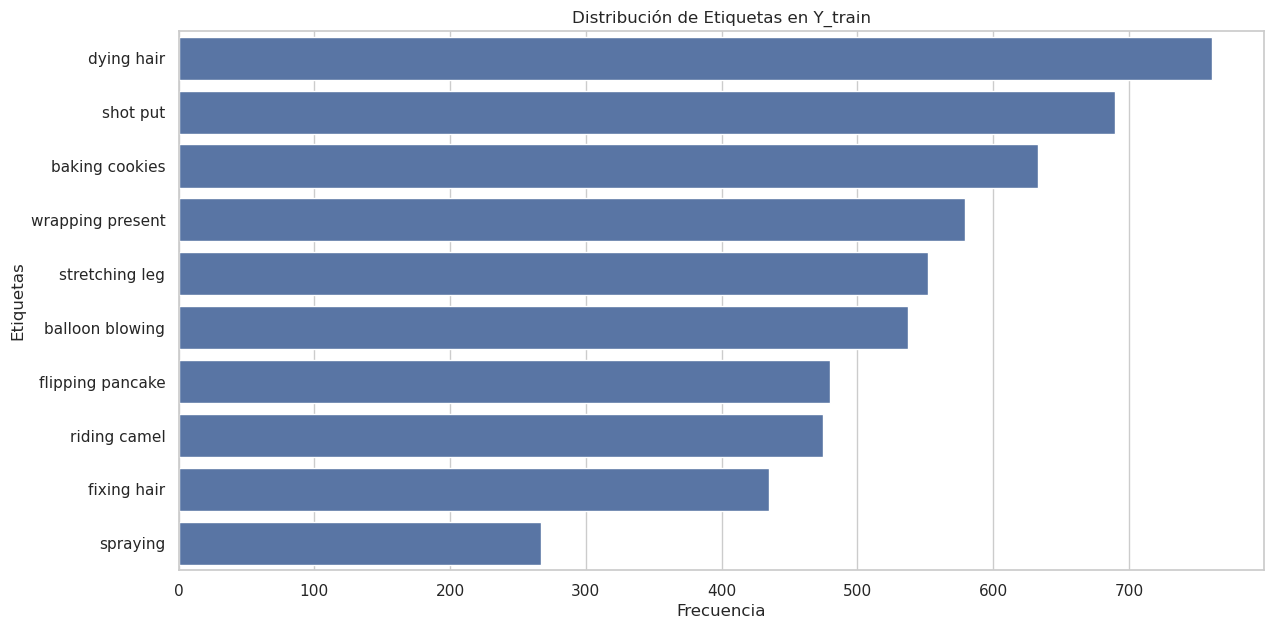

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.countplot(Y_train.iloc[:, 0], order=Y_train.iloc[:, 0].value_counts().index)

# Configurar los títulos y etiquetas
plt.title('Distribución de Etiquetas en Y_train')
plt.xlabel('Frecuencia')
plt.ylabel('Etiquetas')

# Mostrar la gráfica
plt.show()

# 4. Experimentación

In [5]:
# Distintos normalizadores
# scaler = StandardScaler()
# scaler = RobustScaler()
# scaler = QuantileTransformer()
scaler = PowerTransformer()

normalized_data = scaler.fit_transform(X_train)
normalized_val = scaler.transform(X_val)
normalized_test = scaler.transform(X_test)

In [6]:
# Reducir la dimensionalidad usando PCA
pca = PCA(n_components=20)
pca_data = pca.fit_transform(normalized_data)
pca_val = pca.transform(normalized_val)
pca_test = pca.transform(normalized_test)

# Reducir la dimensionalidad usando t-SNE
tsne = TSNE()
tsne_data = tsne.fit_transform(normalized_data)
tsne_val = tsne.fit_transform(normalized_val)
tsne_test = tsne.fit_transform(normalized_test)

# Reducir la dimensionalidad usando UMAP
umap_reducer = umap.UMAP(random_state=2024, n_jobs=1, metric="cosine")
umap_data = umap_reducer.fit_transform(normalized_data)
umap_val = umap_reducer.transform(normalized_val)
umap_test = umap_reducer.transform(normalized_test)

In [7]:
# Reducir la dimensionalidad usando TriMap
trimap_data = trimap.TRIMAP().fit_transform(normalized_data)
trimap_val = trimap.TRIMAP().fit_transform(normalized_val)
trimap_test = trimap.TRIMAP().fit_transform(normalized_test)

# Reducir la dimensionalidad usando PaCMAP
pacmap_data = pacmap.PaCMAP().fit_transform(normalized_data, init="pca")
pacmap_val = pacmap.PaCMAP().fit_transform(normalized_val, init="pca")
pacmap_test = pacmap.PaCMAP().fit_transform(normalized_test, init="pca")

In [8]:
le = preprocessing.LabelEncoder()
Y_train_encoded = le.fit_transform(Y_train.to_numpy().ravel())
Y_val_encoded = le.fit_transform(Y_val.to_numpy().ravel())

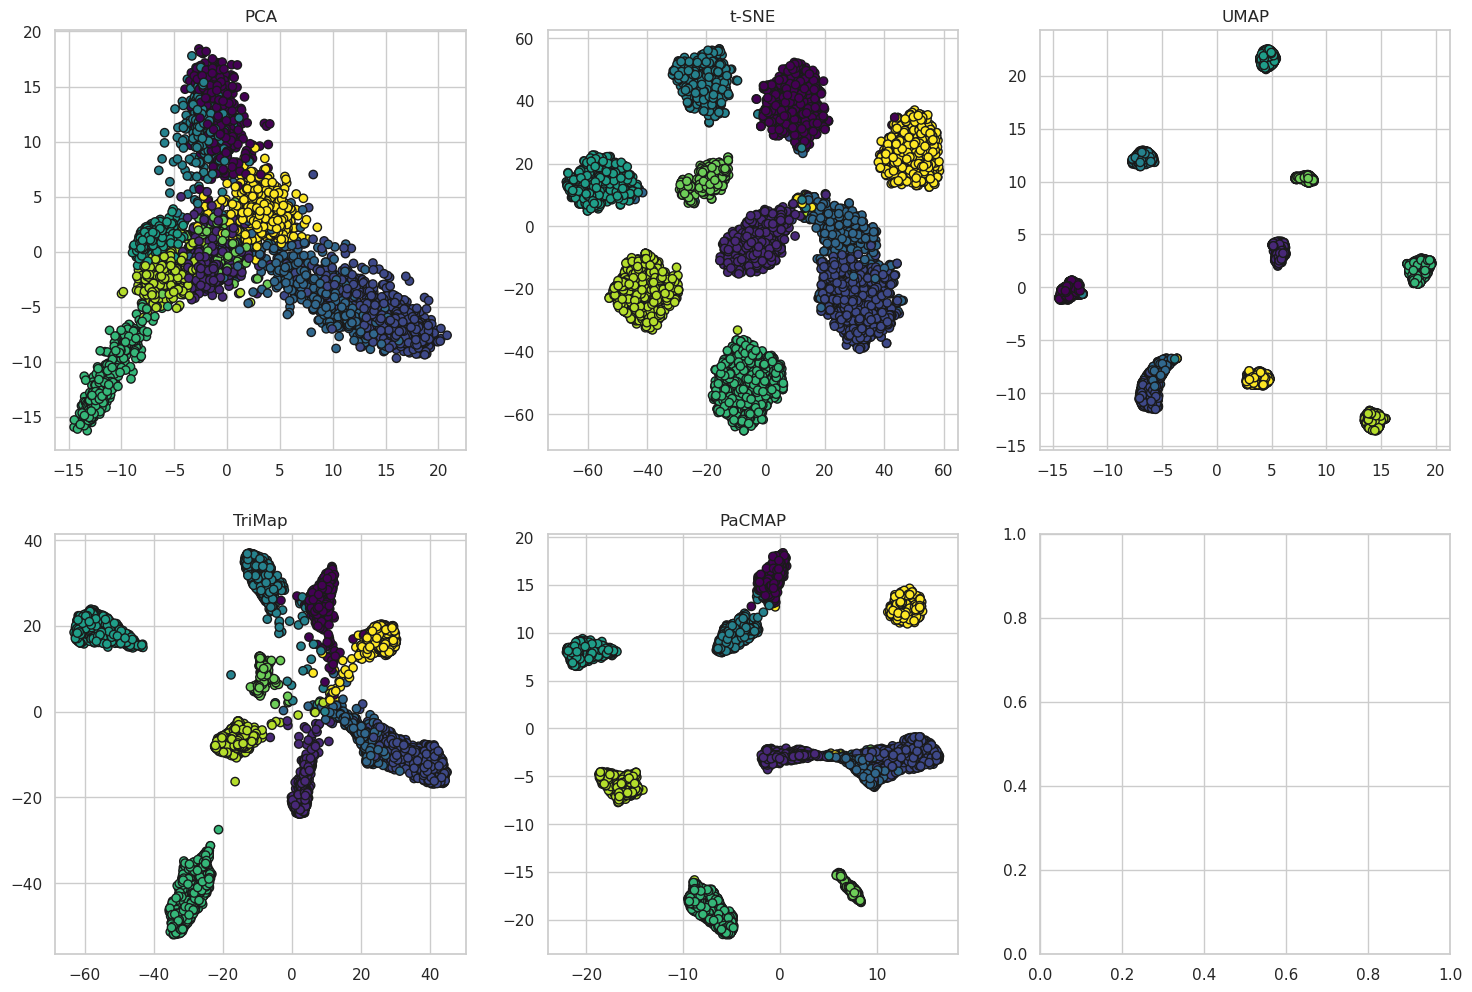

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs[0][0].scatter(pca_data[:, 0], pca_data[:, 1], c=Y_train_encoded, cmap='viridis', edgecolor='k')
axs[0][0].set_title('PCA')
axs[0][1].scatter(tsne_data[:, 0], tsne_data[:, 1], c=Y_train_encoded, cmap='viridis', edgecolor='k')
axs[0][1].set_title('t-SNE')
axs[0][2].scatter(umap_data[:, 0], umap_data[:, 1], c=Y_train_encoded, cmap='viridis', edgecolor='k')
axs[0][2].set_title('UMAP')
axs[1][0].scatter(trimap_data[:, 0], trimap_data[:, 1], c=Y_train_encoded, cmap='viridis', edgecolor='k')
axs[1][0].set_title('TriMap')
axs[1][1].scatter(pacmap_data[:, 0], pacmap_data[:, 1], c=Y_train_encoded, cmap='viridis', edgecolor='k')
axs[1][1].set_title('PaCMAP')
plt.show()

In [16]:
print(f"PCA - Silhouette score: {silhouette_score(pca_data, Y_train_encoded)}")
print(f"t-SNE - Silhouette score: {silhouette_score(tsne_data, Y_train_encoded)}")
print(f"UMAP - Silhouette score: {silhouette_score(umap_data, Y_train_encoded)}")
print(f"TriMap - Silhouette score: {silhouette_score(trimap_data, Y_train_encoded)}")
print(f"PaCMAP - Silhouette score: {silhouette_score(pacmap_data, Y_train_encoded)}")

PCA - Silhouette score: 0.5147688083975915
t-SNE - Silhouette score: 0.6199010014533997
UMAP - Silhouette score: 0.8082196712493896
TriMap - Silhouette score: 0.6716486215591431
PaCMAP - Silhouette score: 0.7080090045928955


In [9]:
def evaluate_clustering(reduced_data, true_labels=None, method_name='', clustering_algorithm='kmeans++', export_labels=False):
    if clustering_algorithm == 'kmeans++':
        # Aplicar K-means++ para clustering en los datos reducidos
        clusterer = MyKMeans(reduced_data, k=10, umbral=0.0004)
        centroids, predicted_labels = clusterer.fit_transform()
    elif clustering_algorithm == 'agglomerative':
        # Aplicar Agglomerative para clustering en los datos reducidos
        clusterer = AgglomerativeHierarchicalClustering(reduced_data, K=10, M='euclidean')
        clusterer.run_algorithm()
        predicted_labels = clusterer.get_cluster_labels()
    elif clustering_algorithm == 'sk_kmeans++':
        # Aplicar K-means++ de SkLearn para clustering en los datos reducidos
        clusterer = KMeans(n_clusters=10, random_state=2024, algorithm='lloyd')
        predicted_labels = clusterer.fit_predict(reduced_data)
    elif clustering_algorithm == 'sk_agglomerative':
        # Aplicar Agglomerative de SkLearn para clustering en los datos reducidos
        clusterer = AgglomerativeClustering(n_clusters=10)
        predicted_labels = clusterer.fit_predict(reduced_data)
    
    # Calcular Silhouette Score
    silhouette_avg = silhouette_score(reduced_data, predicted_labels)

    if true_labels is not None:
        # Calcular Adjusted Rand Index
        ari = adjusted_rand_score(true_labels, predicted_labels)
        
        # Calcular Adjusted Mutual Information
        ami = adjusted_mutual_info_score(true_labels, predicted_labels)

        print(f"{method_name} ({clustering_algorithm}) - Silhouette Score: {silhouette_avg:.4f}, Adjusted Rand Index: {ari:.4f}, Adjusted Mutual Information: {ami:.4f}")
    else:
        print(f"{method_name} ({clustering_algorithm}) - Silhouette Score: {silhouette_avg:.4f}")

    if (export_labels):
        return predicted_labels

In [10]:
def plot_comparison(data, predicted_labels_a, predicted_labels_b, reductor):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].scatter(data[:, 0], data[:, 1], c=predicted_labels_a, cmap='viridis', edgecolor='k')
    axs[0].set_title('Kmeans++')
    axs[1].scatter(data[:, 0], data[:, 1], c=predicted_labels_b, cmap='viridis', edgecolor='k')
    axs[1].set_title('Agglomerative')
    fig.suptitle(f'Comparison of Clustering Methods - {reductor}', fontsize=16)
    plt.show()

### PCA Data Clustering

In [39]:
print("Train", end=" -> \t")
evaluate_clustering(pca_data, Y_train_encoded, "PCA", clustering_algorithm='kmeans++')
print("Validation", end=" -> \t")
evaluate_clustering(pca_val, Y_val_encoded, "PCA", clustering_algorithm='kmeans++')
print("Test", end=" -> \t")
pca_test_k = evaluate_clustering(pca_test, None, "PCA", clustering_algorithm='kmeans++', export_labels=True)
print("\nTrain", end=" -> \t")
evaluate_clustering(pca_data, Y_train_encoded, "PCA", clustering_algorithm='agglomerative')
print("Validation", end=" -> \t")
evaluate_clustering(pca_val, Y_val_encoded, "PCA", clustering_algorithm='agglomerative')
print("Test", end=" -> \t")
pca_test_a = evaluate_clustering(pca_test, None, "PCA", clustering_algorithm='agglomerative', export_labels=True)

Train -> 	PCA (kmeans++) - Silhouette Score: 0.4449, Adjusted Rand Index: 0.8150, Adjusted Mutual Information: 0.8789
Validation -> 	PCA (kmeans++) - Silhouette Score: 0.4495, Adjusted Rand Index: 0.8474, Adjusted Mutual Information: 0.8810
Test -> 	PCA (kmeans++) - Silhouette Score: 0.4396

Train -> 	PCA (agglomerative) - Silhouette Score: 0.4599, Adjusted Rand Index: 0.8250, Adjusted Mutual Information: 0.8963
Validation -> 	PCA (agglomerative) - Silhouette Score: 0.4170, Adjusted Rand Index: 0.7490, Adjusted Mutual Information: 0.8628
Test -> 	PCA (agglomerative) - Silhouette Score: 0.3237


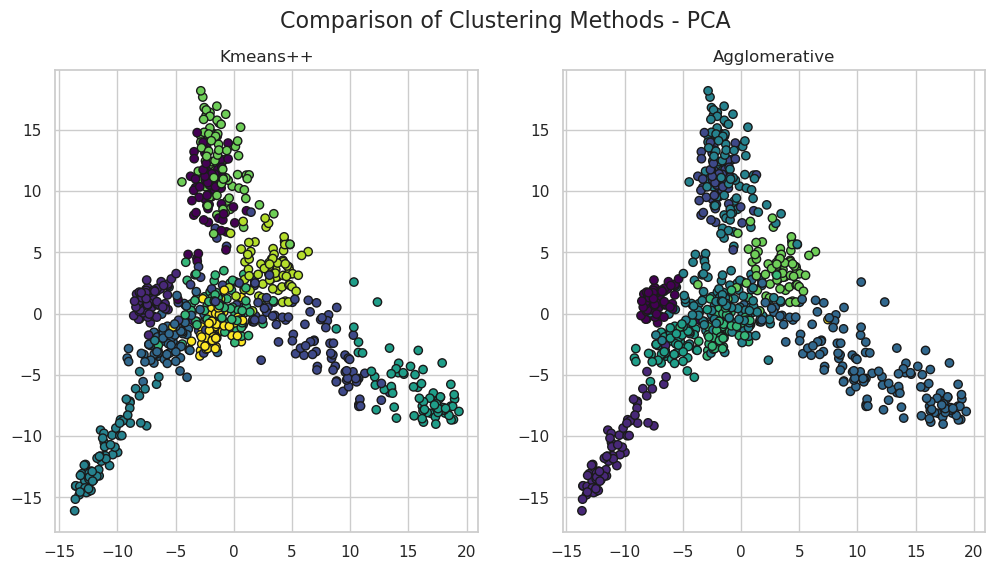

In [40]:
plot_comparison(pca_test, pca_test_k, pca_test_a, 'PCA')

### t-SNE Data Clustering

In [41]:
print("Train", end=" -> \t")
evaluate_clustering(tsne_data, Y_train_encoded, "t-SNE", clustering_algorithm='kmeans++')
print("Validation", end=" -> \t")
evaluate_clustering(tsne_val, Y_val_encoded, "t-SNE", clustering_algorithm='kmeans++')
print("Test", end=" -> \t")
tsn_test_k = evaluate_clustering(tsne_test, None, "t-SNE", clustering_algorithm='kmeans++', export_labels=True)
print("\nTrain", end=" -> \t")
evaluate_clustering(tsne_data, Y_train_encoded, "t-SNE", clustering_algorithm='agglomerative')
print("Validation", end=" -> \t")
evaluate_clustering(tsne_val, Y_val_encoded, "t-SNE", clustering_algorithm='agglomerative')
print("Test", end=" -> \t")
tsn_test_a = evaluate_clustering(tsne_test, None, "t-SNE", clustering_algorithm='agglomerative', export_labels=True)

Train -> 	t-SNE (kmeans++) - Silhouette Score: 0.5022, Adjusted Rand Index: 0.7295, Adjusted Mutual Information: 0.8592
Validation -> 	t-SNE (kmeans++) - Silhouette Score: 0.6407, Adjusted Rand Index: 0.7234, Adjusted Mutual Information: 0.8371
Test -> 	t-SNE (kmeans++) - Silhouette Score: 0.6669

Train -> 	t-SNE (agglomerative) - Silhouette Score: 0.6390, Adjusted Rand Index: 0.9196, Adjusted Mutual Information: 0.9390
Validation -> 	t-SNE (agglomerative) - Silhouette Score: 0.7040, Adjusted Rand Index: 0.8174, Adjusted Mutual Information: 0.8694
Test -> 	t-SNE (agglomerative) - Silhouette Score: 0.6159


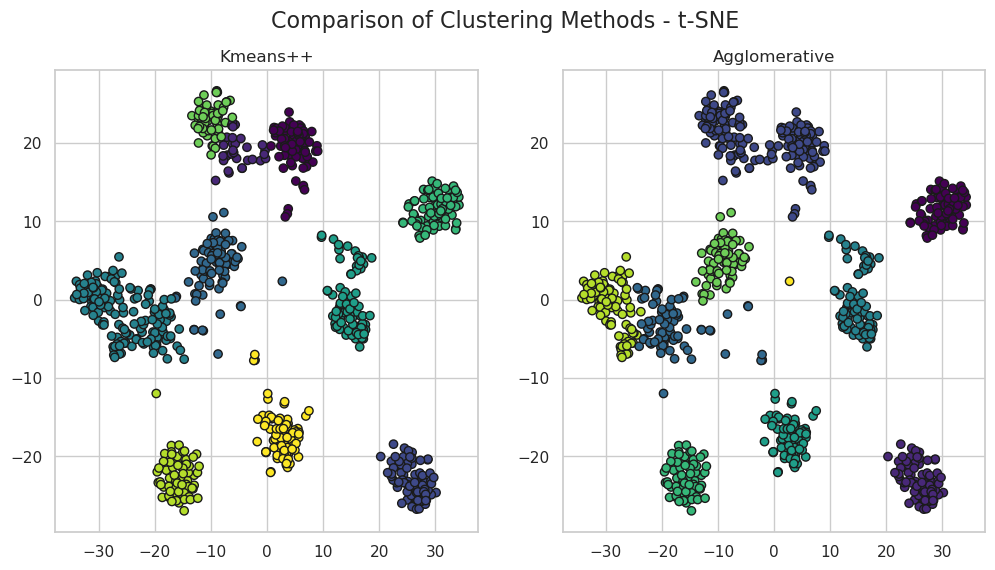

In [42]:
plot_comparison(tsne_test, tsn_test_k, tsn_test_a, 't-SNE')

### UMAP Data Clustering

In [29]:
print("Train", end=" -> \t")
evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='kmeans++')
print("Validation", end=" -> \t")
evaluate_clustering(umap_val, Y_val_encoded, "UMAP", clustering_algorithm='kmeans++')
print("Test", end=" -> \t")
u_test_k = evaluate_clustering(umap_test, None, "UMAP", clustering_algorithm='kmeans++', export_labels=True)
print("\nTrain", end=" -> \t")
evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='agglomerative')
print("Validation", end=" -> \t")
evaluate_clustering(umap_val, Y_val_encoded, "UMAP", clustering_algorithm='agglomerative')
print("Test", end=" -> \t")
u_test_a = evaluate_clustering(umap_test, None, "UMAP", clustering_algorithm='agglomerative', export_labels=True)

Train -> 	UMAP (kmeans++) - Silhouette Score: 0.8529, Adjusted Rand Index: 0.9508, Adjusted Mutual Information: 0.9531
Validation -> 	UMAP (kmeans++) - Silhouette Score: 0.8161, Adjusted Rand Index: 0.8231, Adjusted Mutual Information: 0.9035
Test -> 	UMAP (kmeans++) - Silhouette Score: 0.8445

Train -> 	UMAP (agglomerative) - Silhouette Score: 0.8520, Adjusted Rand Index: 0.9484, Adjusted Mutual Information: 0.9519
Validation -> 	UMAP (agglomerative) - Silhouette Score: 0.8628, Adjusted Rand Index: 0.8524, Adjusted Mutual Information: 0.9204
Test -> 	UMAP (agglomerative) - Silhouette Score: 0.8501


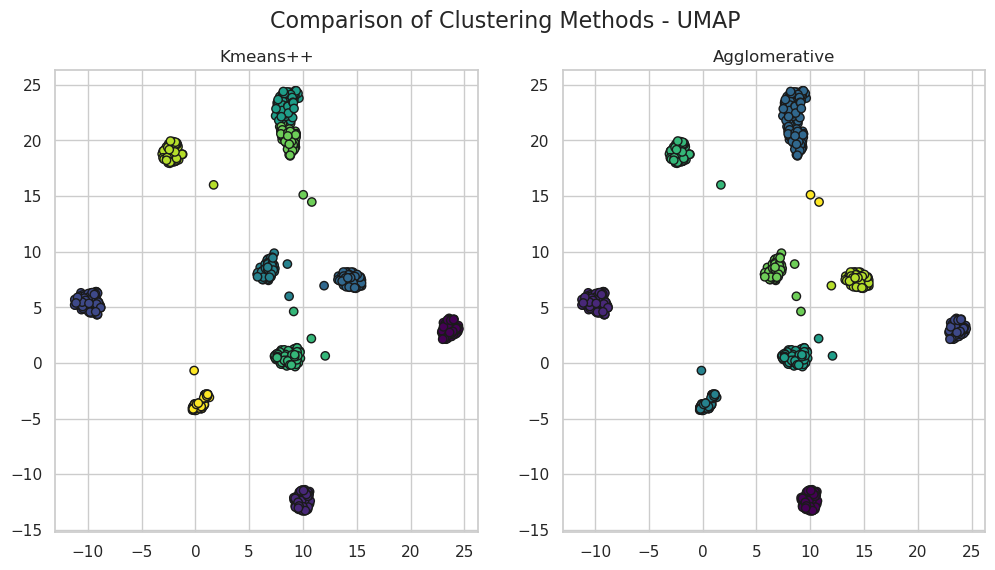

In [38]:
plot_comparison(umap_test, u_test_k, u_test_a, 'UMAP')

### TriMap Data Clustering

In [31]:
print("Train", end=" -> \t")
evaluate_clustering(trimap_data, Y_train_encoded, "TriMap", clustering_algorithm='kmeans++')
print("Validation", end=" -> \t")
evaluate_clustering(trimap_val, Y_val_encoded, "TriMap", clustering_algorithm='kmeans++')
print("Test", end=" -> \t")
tri_test_k = evaluate_clustering(trimap_test, None, "TriMap", clustering_algorithm='kmeans++', export_labels=True)
print("\nTrain", end=" -> \t")
evaluate_clustering(trimap_data, Y_train_encoded, "TriMap", clustering_algorithm='agglomerative')
print("Validation", end=" -> \t")
evaluate_clustering(trimap_val, Y_val_encoded, "TriMap", clustering_algorithm='agglomerative')
print("Test", end=" -> \t")
tri_test_a = evaluate_clustering(trimap_test, None, "TriMap", clustering_algorithm='agglomerative', export_labels=True)

Train -> 	TriMap (kmeans++) - Silhouette Score: 0.6822, Adjusted Rand Index: 0.8508, Adjusted Mutual Information: 0.8989
Validation -> 	TriMap (kmeans++) - Silhouette Score: 0.6275, Adjusted Rand Index: 0.7387, Adjusted Mutual Information: 0.8372
Test -> 	TriMap (kmeans++) - Silhouette Score: 0.6510

Train -> 	TriMap (agglomerative) - Silhouette Score: 0.6612, Adjusted Rand Index: 0.8407, Adjusted Mutual Information: 0.9217
Validation -> 	TriMap (agglomerative) - Silhouette Score: 0.7075, Adjusted Rand Index: 0.7898, Adjusted Mutual Information: 0.8581
Test -> 	TriMap (agglomerative) - Silhouette Score: 0.6495


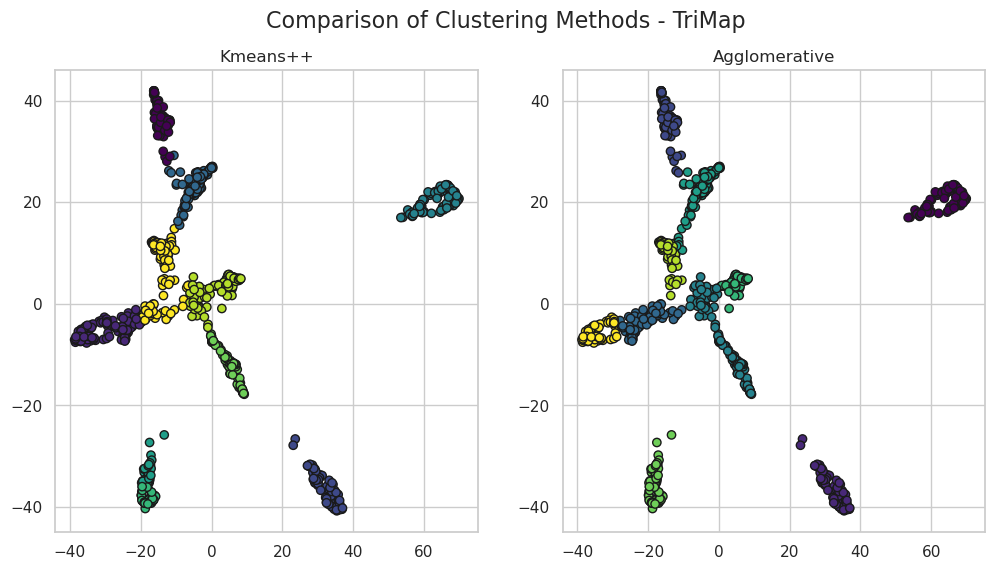

In [35]:
plot_comparison(trimap_test, tri_test_k, tri_test_a, 'TriMap')

### PaCMAP Data Clustering

In [43]:
print("Train", end=" -> \t")
evaluate_clustering(pacmap_data, Y_train_encoded, "PaCMAP", clustering_algorithm='kmeans++')
print("Validation", end=" -> \t")
evaluate_clustering(pacmap_val, Y_val_encoded, "PaCMAP", clustering_algorithm='kmeans++')
print("Test", end=" -> \t")
pacm_test_k = evaluate_clustering(pacmap_test, None, "PaCMAP", clustering_algorithm='kmeans++', export_labels=True)
print("\nTrain", end=" -> \t")
evaluate_clustering(pacmap_data, Y_train_encoded, "PaCMAP", clustering_algorithm='agglomerative')
print("Validation", end=" -> \t")
evaluate_clustering(pacmap_val, Y_val_encoded, "PaCMAP", clustering_algorithm='agglomerative')
print("Test", end=" -> \t")
pacm_test_a = evaluate_clustering(pacmap_test, None, "PaCMAP", clustering_algorithm='agglomerative', export_labels=True)

Train -> 	PaCMAP (kmeans++) - Silhouette Score: 0.7399, Adjusted Rand Index: 0.8201, Adjusted Mutual Information: 0.9111
Validation -> 	PaCMAP (kmeans++) - Silhouette Score: 0.7261, Adjusted Rand Index: 0.7517, Adjusted Mutual Information: 0.8344
Test -> 	PaCMAP (kmeans++) - Silhouette Score: 0.6746

Train -> 	PaCMAP (agglomerative) - Silhouette Score: 0.7463, Adjusted Rand Index: 0.8552, Adjusted Mutual Information: 0.9201
Validation -> 	PaCMAP (agglomerative) - Silhouette Score: 0.6900, Adjusted Rand Index: 0.7496, Adjusted Mutual Information: 0.8332
Test -> 	PaCMAP (agglomerative) - Silhouette Score: 0.6852


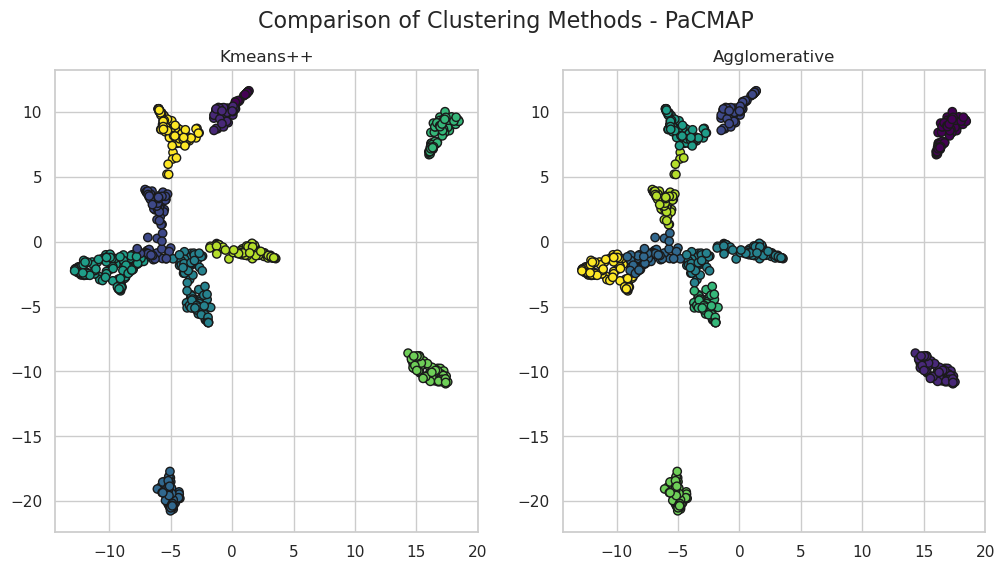

In [44]:
plot_comparison(pacmap_test, pacm_test_k, pacm_test_a, 'PaCMAP')

#### Train to compare vs. Sklearn

In [11]:
print("Train", end=" -> \t")
evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='sk_kmeans++')
print("Validation", end=" -> \t")
evaluate_clustering(umap_val, Y_val_encoded, "UMAP", clustering_algorithm='sk_kmeans++')
print("Test", end=" -> \t")
evaluate_clustering(umap_test, None, "UMAP", clustering_algorithm='sk_kmeans++')
print("\nTrain", end=" -> \t")
evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='sk_agglomerative')
print("Validation", end=" -> \t")
evaluate_clustering(umap_val, Y_val_encoded, "UMAP", clustering_algorithm='sk_agglomerative')
print("Test", end=" -> \t")
evaluate_clustering(umap_test, None, "UMAP", clustering_algorithm='sk_agglomerative')

Train -> 	UMAP (sk_kmeans++) - Silhouette Score: 0.8537, Adjusted Rand Index: 0.9520, Adjusted Mutual Information: 0.9534
Validation -> 	UMAP (sk_kmeans++) - Silhouette Score: 0.8319, Adjusted Rand Index: 0.8806, Adjusted Mutual Information: 0.9000
Test -> 	UMAP (sk_kmeans++) - Silhouette Score: 0.8463

Train -> 	UMAP (sk_agglomerative) - Silhouette Score: 0.8531, Adjusted Rand Index: 0.9491, Adjusted Mutual Information: 0.9517
Validation -> 	UMAP (sk_agglomerative) - Silhouette Score: 0.8320, Adjusted Rand Index: 0.8811, Adjusted Mutual Information: 0.9049
Test -> 	UMAP (sk_agglomerative) - Silhouette Score: 0.8441


In [12]:
print("Train", end=" -> \t")
tmp1 = evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='kmeans++', export_labels=True)
print("Validation", end=" -> \t")
tmp2 = evaluate_clustering(umap_val, Y_val_encoded, "UMAP", clustering_algorithm='kmeans++', export_labels=True)
print("Test", end=" -> \t")
tmp3 = evaluate_clustering(umap_test, None, "UMAP", clustering_algorithm='kmeans++', export_labels=True)
print("\nTrain", end=" -> \t")
tmp4 = evaluate_clustering(umap_data, Y_train_encoded, "UMAP", clustering_algorithm='agglomerative', export_labels=True)
print("Validation", end=" -> \t")
tmp5 = evaluate_clustering(umap_val, Y_val_encoded, "UMAP", clustering_algorithm='agglomerative', export_labels=True)
print("Test", end=" -> \t")
tmp6 = evaluate_clustering(umap_test, None, "UMAP", clustering_algorithm='agglomerative', export_labels=True)

Train -> 	UMAP (kmeans++) - Silhouette Score: 0.8537, Adjusted Rand Index: 0.9520, Adjusted Mutual Information: 0.9534
Validation -> 	UMAP (kmeans++) - Silhouette Score: 0.8494, Adjusted Rand Index: 0.8143, Adjusted Mutual Information: 0.8892
Test -> 	UMAP (kmeans++) - Silhouette Score: 0.7124

Train -> 	UMAP (agglomerative) - Silhouette Score: 0.8324, Adjusted Rand Index: 0.9147, Adjusted Mutual Information: 0.9427
Validation -> 	UMAP (agglomerative) - Silhouette Score: 0.8734, Adjusted Rand Index: 0.8416, Adjusted Mutual Information: 0.9055
Test -> 	UMAP (agglomerative) - Silhouette Score: 0.8736


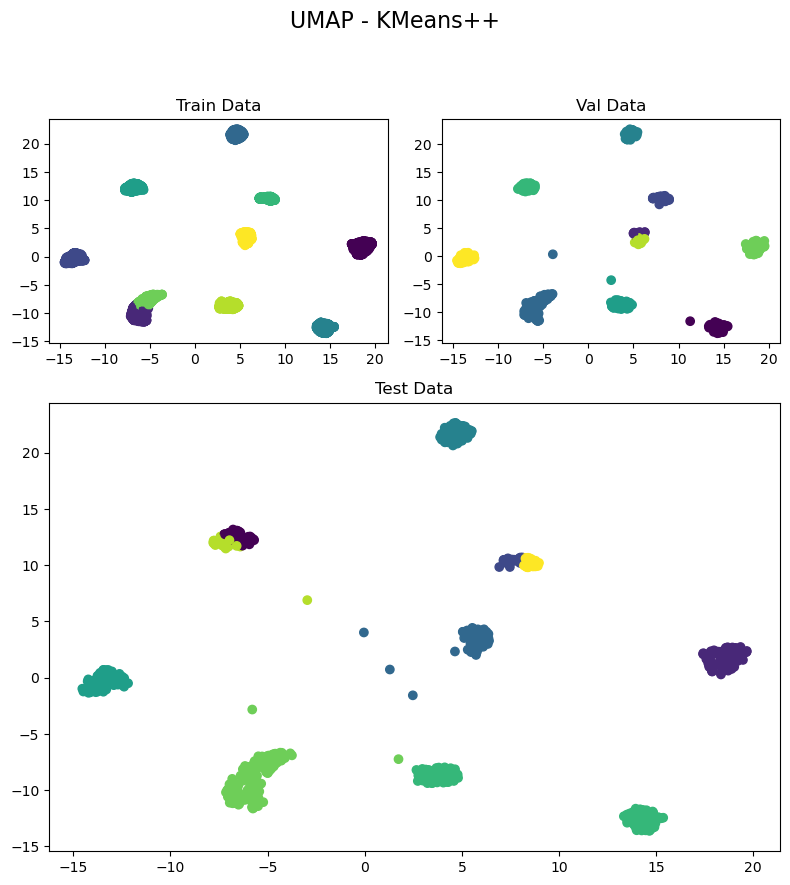

In [48]:
fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(umap_data[:, 0], umap_data[:, 1], c=tmp1, cmap='viridis')
ax1.set_title('Train Data')

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(umap_val[:, 0], umap_val[:, 1], c=tmp2, cmap='viridis')
ax2.set_title('Val Data')

ax3 = fig.add_subplot(gs[1, :])
ax3.scatter(umap_test[:, 0], umap_test[:, 1], c=tmp3, cmap='viridis')
ax3.set_title('Test Data')

fig.suptitle('UMAP - KMeans++', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

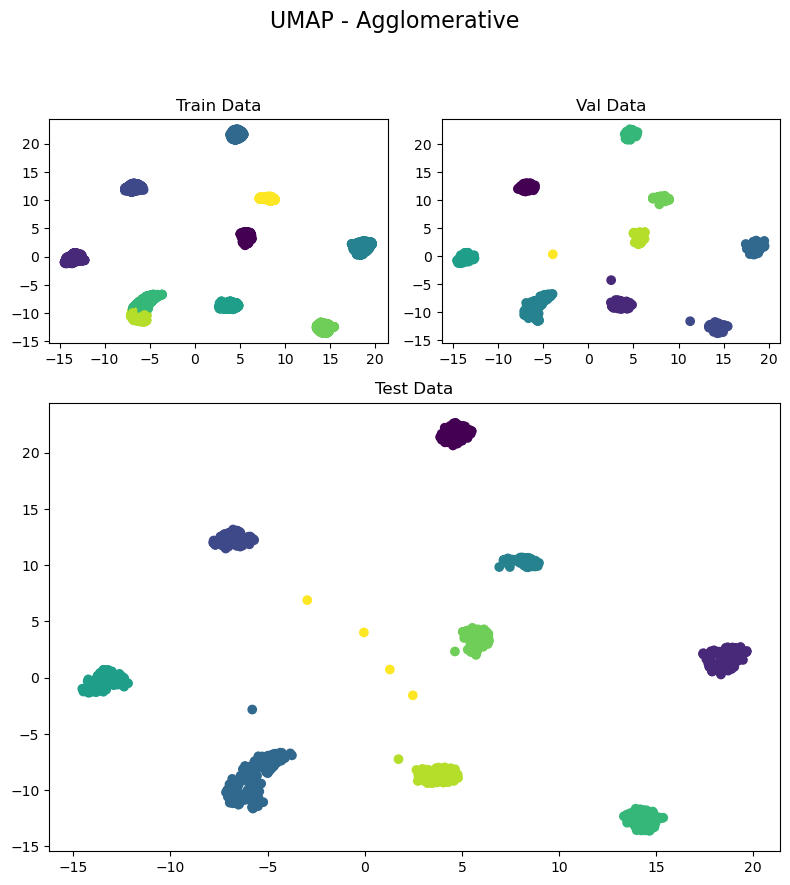

In [50]:
fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(umap_data[:, 0], umap_data[:, 1], c=tmp4, cmap='viridis')
ax1.set_title('Train Data')

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(umap_val[:, 0], umap_val[:, 1], c=tmp5, cmap='viridis')
ax2.set_title('Val Data')

ax3 = fig.add_subplot(gs[1, :])
ax3.scatter(umap_test[:, 0], umap_test[:, 1], c=tmp6, cmap='viridis')
ax3.set_title('Test Data')

fig.suptitle('UMAP - Agglomerative', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [10]:
print("Train", end=" -> \t")
tmp1 = evaluate_clustering(pacmap_data, Y_train_encoded, "PaCMAP", clustering_algorithm='kmeans++', export_labels=True)
print("Validation", end=" -> \t")
tmp2 = evaluate_clustering(pacmap_val, Y_val_encoded, "PaCMAP", clustering_algorithm='kmeans++', export_labels=True)
print("Test", end=" -> \t")
tmp3 = evaluate_clustering(pacmap_test, None, "PaCMAP", clustering_algorithm='kmeans++', export_labels=True)
print("\nTrain", end=" -> \t")
tmp4 = evaluate_clustering(pacmap_data, Y_train_encoded, "PaCMAP", clustering_algorithm='agglomerative', export_labels=True)
print("Validation", end=" -> \t")
tmp5 = evaluate_clustering(pacmap_val, Y_val_encoded, "PaCMAP", clustering_algorithm='agglomerative', export_labels=True)
print("Test", end=" -> \t")
tmp6 = evaluate_clustering(pacmap_test, None, "PaCMAP", clustering_algorithm='agglomerative', export_labels=True)

Train -> 	PaCMAP (kmeans++) - Silhouette Score: 0.7194, Adjusted Rand Index: 0.8360, Adjusted Mutual Information: 0.9143
Validation -> 	PaCMAP (kmeans++) - Silhouette Score: 0.6904, Adjusted Rand Index: 0.7909, Adjusted Mutual Information: 0.8695
Test -> 	PaCMAP (kmeans++) - Silhouette Score: 0.7296

Train -> 	PaCMAP (agglomerative) - Silhouette Score: 0.7529, Adjusted Rand Index: 0.8679, Adjusted Mutual Information: 0.9224
Validation -> 	PaCMAP (agglomerative) - Silhouette Score: 0.6415, Adjusted Rand Index: 0.7346, Adjusted Mutual Information: 0.8362
Test -> 	PaCMAP (agglomerative) - Silhouette Score: 0.6756


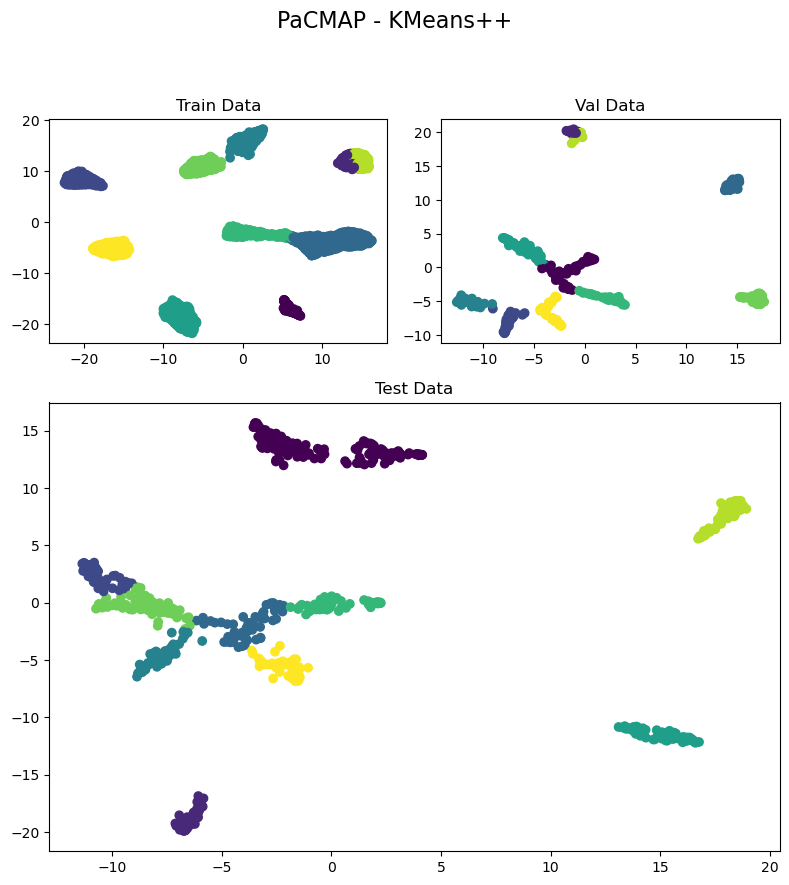

In [13]:
fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(pacmap_data[:, 0], pacmap_data[:, 1], c=tmp1, cmap='viridis')
ax1.set_title('Train Data')

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(pacmap_val[:, 0], pacmap_val[:, 1], c=tmp2, cmap='viridis')
ax2.set_title('Val Data')

ax3 = fig.add_subplot(gs[1, :])
ax3.scatter(pacmap_test[:, 0], pacmap_test[:, 1], c=tmp3, cmap='viridis')
ax3.set_title('Test Data')

fig.suptitle('PaCMAP - KMeans++', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

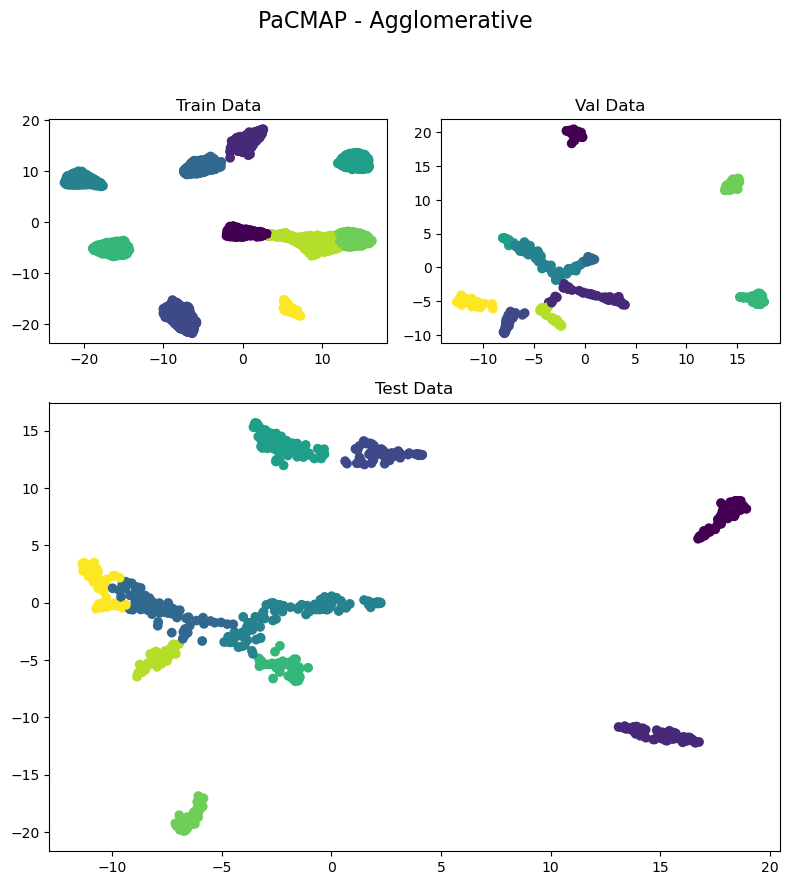

In [15]:
fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(pacmap_data[:, 0], pacmap_data[:, 1], c=tmp4, cmap='viridis')
ax1.set_title('Train Data')

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(pacmap_val[:, 0], pacmap_val[:, 1], c=tmp5, cmap='viridis')
ax2.set_title('Val Data')

ax3 = fig.add_subplot(gs[1, :])
ax3.scatter(pacmap_test[:, 0], pacmap_test[:, 1], c=tmp6, cmap='viridis')
ax3.set_title('Test Data')

fig.suptitle('PaCMAP - Agglomerative', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# _. Dump to CSV

In [13]:
def create_clustered_dataframe(df_test_labels, clusters, missing_indices, output_csv_path):
    # Verificar que la longitud de clusters sea la adecuada
    expected_length = len(df_test_labels)
    if len(clusters) != expected_length - len(missing_indices):
        raise ValueError(f"La longitud de 'clusters' ({len(clusters)}) no coincide con la longitud esperada ({expected_length - len(missing_indices)})")
    
    # Crear un DataFrame con youtube_id y sus clusters correspondientes
    clustered_data = []
    missing_index_set = set(missing_indices)
    cluster_index = 0
    
    for i, (index, row) in enumerate(df_test_labels.iterrows()):
        if i in missing_index_set:
            clustered_data.append({'youtube_id': row['youtube_id'], 'label': 0})
        else:
            clustered_data.append({'youtube_id': row['youtube_id'], 'label': clusters[cluster_index]})
            cluster_index += 1
    
    # Convertir a DataFrame
    df_clustered = pd.DataFrame(clustered_data)
    
    # Guardar el DataFrame resultante en un archivo CSV
    df_clustered.to_csv(output_csv_path, index=False)

create_clustered_dataframe(df_test_labels, u_test_k, missing_indices, './clustered_test_labels.csv')